In [1]:
import numpy as np
import os
import scipy.stats as stats
import scipy.io as io
import networkx as nx
import random
import itertools
import glob
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,roc_curve,roc_auc_score
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from scipy.io import loadmat, savemat
#from fracModel import fracOrdUU
from collections import Counter
from collections import defaultdict
from numpy import arange,array,ones,linalg
from sklearn.linear_model import LinearRegression
import pandas as pd
import powerlaw
import os.path
from os import path
import warnings
warnings.filterwarnings("ignore")
import pickle
import ast

In [2]:
##Calculate entropy
def Entropy_MC(s,b,k,beta,gamma,st_in,l):
    #s = s[st_in:min(st_in+l,len(s))]+s[26000:len(s)]
    s = s[st_in:min(st_in+l,len(s))]
    inv, l, n = k-b, len(s), 4**k
    T=np.zeros((n,n))
    count = [0]*n
    word_list = [''.join(x) for x in itertools.product('acgt', repeat=k)]
    wd = dict(zip(word_list, list(range(len(word_list)))))
    uu = []
    for i in range(k,l-b):
        n1, n2 = wd[s[i-k:i]], wd[s[i-k+b:i+b]]
        T[n1,n2] += 1
        count[n1] += 1
        
    wo_next = [''.join(x) for x in itertools.product('acgt', repeat=b)]
    for i in range(n):
        wo = word_list[i]
        for l in wo_next:
            j = wd[wo[b:]+l]
            T[i,j] = (T[i,j]+beta)/(count[i]+4**b*beta)
    sum_count = np.sum(count)+4**k*gamma
    
    prob = [(count[i]+gamma)/sum_count for i in range(len(count))] 
    n = len(T)
    H = 0
    F = []
    for i in range(n):
        wo = word_list[i]
        for l in wo_next:
            j = wd[wo[b:]+l]
            F.append(T[i,j])
            H-=prob[i]*T[i,j]*np.log2(T[i,j])
    return F,H

In [3]:
from collections import defaultdict
def getSeqs(filename):
    seq_list = defaultdict(list)
    mapseq_list = defaultdict(list)
    mapping = {'A': 'a', 'T': 't', 'C': 'c', 'G': 'g','a': 'a', 't': 't', 'c': 'c', 'g': 'g'}
    with open(filename) as f:
        j = -1
        for i, line in enumerate(f):
            if line.startswith('>'):
                j += 1
            else:
                this_line = list(line)
                this_line = list(filter(lambda ch: ch in 'acgtACGT', this_line))
                seq_list[j].extend(this_line)
                mapseq_list[j] = ''.join(list(map(lambda ch: mapping[ch], seq_list[j])))
    return mapseq_list

In [4]:
def stats(s,b,k,beta,gamma,st_in,l):
    F_list = []
    en_list=[]
    for i in range(len(s)):
        F_1,en = Entropy_MC(s[i],b,k,beta,gamma,st_in,l) #Transition Probability vector
        F = F_1
        F_list.append(F)
        en_list.append(en)
    return F_list,en_list

In [5]:
def conv_index(b,k,ind):
    word_list = [''.join(x) for x in itertools.product('acgt', repeat=k)]
    wd_next = [''.join(x) for x in itertools.product('acgt', repeat=b)]
    l = 4**b
    rem = ind%l
    st =' -> '+wd_next[rem]
    num = int(ind/l)
    st = word_list[num]+st
    return st
def normalize(x):
        return (x - x.min(0)) / x.ptp(0)

In [6]:
def ML(b,k,V,beta,gamma,classes,st_in,l):
    word_list = [''.join(x) for x in itertools.product('acgt', repeat=k)]
    wd_next = [''.join(x) for x in itertools.product('acgt', repeat=b)]
    X = []
    y = []
    ct = 0
    n = len(V)
    G = [[] for i in range(n)]
    
    for seq in V:
        for s in seq:
            F_list,en_list = stats(s,b,k,beta,gamma,st_in,l)
            G[ct]+=F_list
        print(len(G[ct]))
        ct+=1
    
    
    min_val = float('inf')
    for i in range(n):
        if min_val > len(G[i]):
            min_val = len(G[i])
   
    
    for i in range(n):
        random.shuffle(G[i])
        X+=[G[i][j] for j in range(len(G[i]))]
        y+=[i for j in range(len(G[i]))]
  
    X_original = [x_i for x_i in X]
    X = np.array(X)
    y = np.array(y)
    X_original = np.array(X_original)
    X = preprocessing.scale(X)
    U_X = list(X[:min_val])
    U_y = list(y[:min_val])
    T_X = list(X[min_val:len(G[0])])
    T_y = list(y[min_val:len(G[0])])
    running_sum = len(G[0])
    for i in range(1,n):
        U_X+=list(X[running_sum:running_sum+min_val])
        U_y+=list(y[running_sum:running_sum+min_val])
        T_X+=list(X[running_sum+min_val:running_sum+len(G[i])])
        T_y+=list(y[running_sum+min_val:running_sum+len(G[i])])
        running_sum+=len(G[i])
    zipped_U = list(zip(U_X,U_y))
    random.shuffle(zipped_U)
    U_X = [x_i for x_i,_ in zipped_U]
    U_y = [y_i for _,y_i in zipped_U]
    zipped_T = list(zip(T_X,T_y))
    random.shuffle(zipped_T)
    T_X = [x_i for x_i,_ in zipped_T]
    T_y = [y_i for _,y_i in zipped_T]
    U_X = np.array(U_X)
    U_y = np.array(U_y)
    print('Length of X: {}'.format(len(U_y)))
    T_X = np.array(T_X)
    T_y = np.array(T_y)
    return U_X,U_y,X_original,T_X,T_y


In [7]:
def build_model(X,y,X_original,b,k,rr,cutoff,T,y_T,f):    #Building model for feature selection
    kf = KFold(n_splits = 4)
    Acc = []
    Acc_T = []
    sc_prob_T = []
    n = len(rr)
    val_score = [[] for i in range(n)]
    feat_set = set()
    feat_set_ind = set()
    D = {}
    X_orig_mean = np.mean(X_original,axis = 0)
    X_orig_std = np.std(X_original,axis = 0)
    fig, ax = plt.subplots()
    gg = 0
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    prec = []
    rec = []
    n_dim = 4**(k+b) 
    acc_list = []
    plt.rcParams.update({'font.size': 14})
    for train, test in kf.split(X):
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        model = XGBClassifier(max_depth=1)
        model.fit(X_train, y_train)
        imp_feat = model.feature_importances_
        imp_indices = np.argsort(imp_feat)
        for im in range(cutoff,0,1):
            transit = conv_index(b,k,imp_indices[im])
            D[transit]  = (round(X_orig_mean[imp_indices[im]],2),round(X_orig_std[imp_indices[im]],4))
            feat_set.add(transit)
            feat_set_ind.add(imp_indices[im])
        
        imp_feat.sort()
        #feature selection and rebuilding the model using selected features
        thresh = imp_feat[cutoff]
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        selection_model = LogisticRegression()
        selection_model.fit(select_X_train, y_train)
        select_X_test = selection.transform(X_test)
        scores = selection_model.predict(select_X_test)
        scores_prob = selection_model.predict_proba(select_X_test)
        if len(T) > 0:
            select_T = selection.transform(T)
            scores_T = selection_model.predict(select_T)
            scores_prob_T = selection_model.predict_proba(select_T)
            Acc_T.append(accuracy_score(scores_T,y_T))
            sc_prob_T+=list(scores_prob_T)
        ctr = 0
        for yy in y_test:
            val_score[yy].append(scores_prob[ctr])
            ctr+=1
        ctr = 0
        val_score_dis = [0 for i in range(n)]
        ctx = [0 for i in range(n)]
        for yy in y_test:
            if scores[ctr] == yy:
                val_score_dis[yy]+=1
            ctx[yy]+=1
            ctr+=1
        for yc in range(n):
            val_score_dis[yc] = val_score_dis[yc]/ctx[yc]*100
        acc_list.append(val_score_dis)
        imp_feat_main = selection_model.coef_
        
        Acc.append(accuracy_score(scores,y_test))
        
        gg+=1
    Acc = np.array(Acc)
    val_score = np.array(val_score)
    if len(T)> 0:
        Acc_T = np.array(Acc_T)
        
    plt.rcParams.update({'font.size': 18})
    acc_list_mean = np.mean(acc_list,axis =0)
    acc_list_std = np.std(acc_list,axis =0)
    
    for i in range(n):
        probs_mean = np.mean(val_score[i],axis = 0)
        probs_std = np.std(val_score[i],axis = 0)
        
        plt.bar(rr,probs_mean,yerr=probs_std, align='center', color=['red', 'green','blue','orange','magenta'], ecolor='black', capsize=10)
        plt.ylabel('Probability')
        plt.title('{} classification probability'.format(rr[i]))
        
        plt.tight_layout()
        plt.close()
        
    
    
            
    print("Important Features: {}".format(feat_set))
    f.write(str(D)+'\n')
    f.write(str(feat_set_ind)+'\n')
        
    return np.mean(Acc),np.std(Acc)

209
207
Length of X: 414
414
Important Features: {'actt -> c', 'tgtt -> t', 'actc -> g', 'aagg -> c', 'aaaa -> c', 'attg -> a', 'cgga -> a', 'gttg -> c', 'ctcc -> t', 'caaa -> c', 'taat -> t', 'ctcc -> c', 'tgtt -> a', 'cact -> c', 'tgtg -> g', 'tcca -> c', 'actt -> a', 'taat -> a', 'aaaa -> a', 'acga -> a', 'ctcc -> g', 'tatg -> a', 'taac -> t', 'ttgt -> c', 'tcag -> t', 'tttt -> c', 'actt -> t', 'aatg -> c', 'aaaa -> t', 'tcat -> g', 'atta -> t', 'ttaa -> c'}
0.6109036594473487+/-0.051862749978989306

209
1732
Length of X: 418
418
Important Features: {'aatg -> a', 'gtgg -> t', 'gaca -> a', 'agct -> t', 'aacc -> a', 'tctg -> a', 'tggc -> g', 'caac -> a', 'aaaa -> a', 'gaca -> g', 'tgac -> t', 'agct -> c', 'atag -> c', 'aact -> g', 'tctg -> g', 'tagc -> t', 'aatg -> c', 'gtga -> t', 'tagc -> c', 'ccaa -> c', 'ttaa -> c'}
0.8135302197802198+/-0.028224475355688



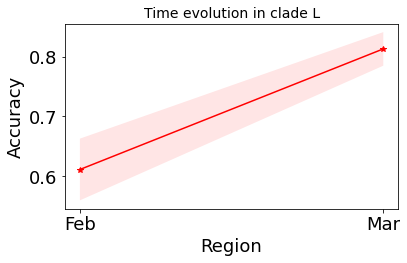

In [11]:
beta = 0.5
gamma = 0.5
cutoff = -10
plt.rcParams.update({'font.size': 20})
V = []
with open('May_G.pkl','rb') as g:
    W = pickle.load(g)
V.append(W[0])

with open('Jun_G.pkl','rb') as g:
    W = pickle.load(g)
V.append(W[0])

with open('Jul_G.pkl','rb') as g:
    W = pickle.load(g)
V.append(W[0])

with open('Aug_G.pkl','rb') as g:
    W = pickle.load(g)
V.append(W[0])

with open('Sep_G.pkl','rb') as g:
    W = pickle.load(g)
V.append(W[0])

with open('Oct_G.pkl','rb') as g:
    W = pickle.load(g)
V.append(W[0])

b = 1
k = 4
st_in = 0
intervals = ['Jun','Jul','Aug','Sep','Oct']
colors = ['red','blue','green','orange','magenta','indigo','cyan','turquoise']

f = open('dummy.txt','w')

st_in = 0
l = 30000
acc_mean = []
acc_std = []
for j in range(1,len(V)):
    classes = ['A','B']
    C = V[0]
    D = V[j]
    V_1 = []
    V_1 = [C,D]
    X,y,X_original,T,y_T = ML(b,k,V_1,beta,gamma,classes,st_in,l)
    print(len(y))
    mean,std = build_model(X,y,X_original,b,k,classes,cutoff,T,y_T,f)
    acc_mean.append(mean)
    acc_std.append(std) 
    print(str(mean)+'+/-'+str(std)+'\n')
acc_mean = np.array(acc_mean)
acc_std = np.array(acc_std)
plt.plot(intervals,acc_mean,'r*-')
plt.fill_between(intervals,acc_mean+acc_std,acc_mean-acc_std,facecolor = 'red',alpha = 0.1)
plt.title('Time evolution in clade G',fontsize = 14)
plt.xlabel('Region')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('time_evolution_clade_G.png', dpi = 300)
plt.show()
plt.close()
f.close()